# qtpg

### imports

In [1]:
import numpy as np
import pandas as pd
import random
import time
from IPython.display import clear_output

### Downing fig 11 GridWorld
#### GridWorld is based on fig 11 from Downing's "Reinforced Genetic Programming" paper
![DowningFig11](downing_fig_11.png)

In [2]:
# will use Downing fig 11 for testing on this
class Figure11:
    def __init__ (self, rows, cols, win_state, start_state):
        self.memory = []
        self.memory_position = 0
        self.memory_limit = 20
        self.rows = rows
        self.cols = cols
        self.start_state = start_state
        self.win_state = win_state
        self.current_state = self.start_state
        
    def sample_action (self):
        rand = random.uniform(0, 1)
        if (rand >= 0) and (rand < 0.25):
            return 0
        elif (rand >= 0.25) and (rand < 0.5):
            return 1
        elif (rand >= 0.5) and (rand < 0.75):
            return 2
        else:
            return 3
        
    def reset (self):
        self.current_state = self.start_state
        return self.current_state
        
    # just reset for now...
    def close (self):
        self.current_state = self.start_state
        return 1
    
    def check_win (self):
        if self.current_state == self.win_state:
            return True
        return False
    
    def step (self, action):
        # north
        if action == 0:
            next = (self.current_state[0] - 1, self.current_state[1])
        # south
        elif action == 1:
            next = (self.current_state[0] + 1, self.current_state[1])
        # east
        elif action == 2:
            next = (self.current_state[0], self.current_state[1] + 1)
        # west
        else:
            next = (self.current_state[0], self.current_state[1] - 1)

        terminate = False
        reward = 0
        # check if move is legal
        if (next[0] >= 0 and next[0] <= (self.rows-1)) and (next[1] >= 0 and next[1] <= (self.cols-1)):            
            illegal = 0
            if (next == (1, 2)) or (next == (1, 3)) or (next == (2, 2)) or (next == (2, 3)):
                illegal = 1
                    
            if (illegal == 0):
                self.current_state = next
                reward += 0.1
                #reward -= 0.01
            else:
                reward -= 0.01
                #reward -= 1
                #reward = reward
        else:
            reward -= 0.01
            #reward -= 1
            #reward = reward
            
        # punish repeat states within last 20 states
        if self.current_state in self.memory:
            reward -= 0.01
            #reward -= 1
            #reward = reward
        
        if self.check_win():
            reward += 100
            terminate = True
        
        # add new state to memory
        if len(self.memory) <= self.memory_limit:
            (self.memory).append(self.current_state)
        # after memory is full, begin overriding it
        else:
            if self.memory_position < self.memory_limit:
                self.memory[self.memory_position] = self.current_state
                self.memory_position += 1
            else:
                self.memory_position = 0
                self.memory[self.memory_position] = self.current_state
        
        return self.current_state, reward, terminate
    
    def animate_path(self, sequence):
        current_map = np.zeros((5, 5))
        # add barrier
        current_map[(1, 2)] = 5
        current_map[(1, 3)] = 5
        current_map[(2, 2)] = 5
        current_map[(2, 3)] = 5
        current_map[self.win_state] = 8

        # animate the run!
        for i in range(len(sequence)):
            time.sleep(0.5)
            if i == 0:
                current_map[sequence[i]] = 1
                clear_output(wait=True)
                print(0)
                print(current_map)
            else:
                current_map[sequence[i-1]] = 0
                current_map[sequence[i]] = 1
                clear_output(wait=True)
                print(i)
                print(current_map)

### Downing fig 12 GridWorld
#### GridWorld is based on fig 12 from Downing's "Reinforced Genetic Programming" paper
![DowningFig11](downing_fig_12.png)

In [3]:
# will use Downing fig 12 for testing on this
class Figure12:
    def __init__ (self, rows, cols, win_state, start_state):
        self.memory = []
        self.memory_position = 0
        self.memory_limit = 20
        self.rows = rows
        self.cols = cols
        self.start_state = start_state
        self.win_state = win_state
        self.current_state = self.start_state
        
    def sample_action (self):
        rand = random.uniform(0, 1)
        if (rand >= 0) and (rand < 0.25):
            return 0
        elif (rand >= 0.25) and (rand < 0.5):
            return 1
        elif (rand >= 0.5) and (rand < 0.75):
            return 2
        else:
            return 3
        
    def reset (self):
        self.current_state = self.start_state
        return self.current_state
        
    # just reset for now...
    def close (self):
        self.current_state = self.start_state
        return 1
    
    def check_win (self):
        if self.current_state == self.win_state:
            return True
        return False
    
    def step (self, action):
        # north
        if action == 0:
            next = (self.current_state[0] - 1, self.current_state[1])
        # south
        elif action == 1:
            next = (self.current_state[0] + 1, self.current_state[1])
        # east
        elif action == 2:
            next = (self.current_state[0], self.current_state[1] + 1)
        # west
        else:
            next = (self.current_state[0], self.current_state[1] - 1)

        terminate = False
        reward = 0
        # check if move is legal
        if (next[0] >= 0 and next[0] <= (self.rows-1)) and (next[1] >= 0 and next[1] <= (self.cols-1)):            
            illegal = 0
            if (next == (2, 0)) or (next == (1, 1)) or (next == (2, 1)) or (next == (1, 3)) or (next == (2, 3)) or (next == (2, 4)):
                illegal = 1
                    
            if (illegal == 0):
                self.current_state = next
                reward += 0.1
                #reward -= 0.01
            else:
                reward -= 0.01
                #reward -= 1
                #reward = reward
        else:
            reward -= 0.01
            #reward -= 1
            #reward = reward
            
        # punish repeat states within last 20 states
        if self.current_state in self.memory:
            reward -= 0.01
            #reward -= 1
            #reward = reward
        
        if self.check_win():
            reward += 100
            terminate = True
        
        # add new state to memory
        if len(self.memory) <= self.memory_limit:
            (self.memory).append(self.current_state)
        # after memory is full, begin overriding it
        else:
            if self.memory_position < self.memory_limit:
                self.memory[self.memory_position] = self.current_state
                self.memory_position += 1
            else:
                self.memory_position = 0
                self.memory[self.memory_position] = self.current_state
        
        return self.current_state, reward, terminate
    
    def animate_path(self, sequence):
        current_map = np.zeros((5, 5))
        # add barrier
        current_map[(2, 0)] = 5
        current_map[(1, 1)] = 5
        current_map[(2, 1)] = 5
        current_map[(1, 3)] = 5
        current_map[(2, 3)] = 5
        current_map[(2, 4)] = 5
        current_map[self.win_state] = 8

        # animate the run!
        for i in range(len(sequence)):
            time.sleep(0.5)
            if i == 0:
                current_map[sequence[i]] = 1
                clear_output(wait=True)
                print(0)
                print(current_map)
            else:
                current_map[sequence[i-1]] = 0
                current_map[sequence[i]] = 1
                clear_output(wait=True)
                print(i)
                print(current_map)

### Downing fig 13 GridWorld
#### GridWorld is based on fig 13 from Downing's "Reinforced Genetic Programming" paper
![DowningFig11](downing_fig_13.png)

In [4]:
# will use Downing fig 13 for testing on this
class Figure13:
    def __init__ (self, rows, cols, win_state, start_state):
        self.memory = []
        self.memory_position = 0
        self.memory_limit = 20
        self.rows = rows
        self.cols = cols
        self.start_state = start_state
        self.win_state = win_state
        self.current_state = self.start_state
        
    def sample_action (self):
        rand = random.uniform(0, 1)
        if (rand >= 0) and (rand < 0.25):
            return 0
        elif (rand >= 0.25) and (rand < 0.5):
            return 1
        elif (rand >= 0.5) and (rand < 0.75):
            return 2
        else:
            return 3
        
    def reset (self):
        self.current_state = self.start_state
        return self.current_state
        
    # just reset for now...
    def close (self):
        self.current_state = self.start_state
        return 1
    
    def check_win (self):
        if self.current_state == self.win_state:
            return True
        return False
    
    def step (self, action):
        # north
        if action == 0:
            next = (self.current_state[0] - 1, self.current_state[1])
        # south
        elif action == 1:
            next = (self.current_state[0] + 1, self.current_state[1])
        # east
        elif action == 2:
            next = (self.current_state[0], self.current_state[1] + 1)
        # west
        else:
            next = (self.current_state[0], self.current_state[1] - 1)

        terminate = False
        reward = 0
        # check if move is legal
        if (next[0] >= 0 and next[0] <= (self.rows-1)) and (next[1] >= 0 and next[1] <= (self.cols-1)):            
            illegal = 0
            if (next == (2, 0)) or (next == (1, 1)) or (next == (2, 1)) or (next == (1, 3)) or (next == (2, 3)) or (next == (3, 3)) or (next == (3, 4)):
                illegal = 1
                    
            if (illegal == 0):
                self.current_state = next
                reward += 0.1
                #reward -= 0.01
            else:
                reward -= 0.01
                #reward -= 1
                #reward = reward
        else:
            reward -= 0.01
            #reward -= 1
            #reward = reward
            
        # punish repeat states within last 20 states
        if self.current_state in self.memory:
            reward -= 0.01
            #reward -= 1
            #reward = reward
        
        if self.check_win():
            print('Winner Winner Chicken Dinner!')
            reward += 100
            terminate = True
        
        # add new state to memory
        if len(self.memory) <= self.memory_limit:
            (self.memory).append(self.current_state)
        # after memory is full, begin overriding it
        else:
            if self.memory_position < self.memory_limit:
                self.memory[self.memory_position] = self.current_state
                self.memory_position += 1
            else:
                self.memory_position = 0
                self.memory[self.memory_position] = self.current_state
        
        return self.current_state, reward, terminate
    
    def animate_path(self, sequence):
        current_map = np.zeros((5, 5))
        # add barrier
        current_map[(2, 0)] = 5
        current_map[(1, 1)] = 5
        current_map[(2, 1)] = 5
        current_map[(1, 3)] = 5
        current_map[(2, 3)] = 5
        current_map[(3, 3)] = 5
        current_map[(3, 4)] = 5
        current_map[self.win_state] = 8

        # animate the run!
        for i in range(len(sequence)):
            time.sleep(0.5)
            if i == 0:
                current_map[sequence[i]] = 1
                clear_output(wait=True)
                print(0)
                print(current_map)
            else:
                current_map[sequence[i-1]] = 0
                current_map[sequence[i]] = 1
                clear_output(wait=True)
                print(i)
                print(current_map)

### Reinforcement Learning Functions

In [5]:
class q_table: 
    def __init__ (self):
        self.q = []
    
    def create (self, agents):
        for agent in agents:
            team = agent.team
            for learner in team.learners:
                # randomize actions of the learners
                action_list = [1, 2, 3, 4]
                random.shuffle(action_list)
                actions = random.randint(1,4)
                for i in range(actions):
                    (self.q).append({'team': str(team.id), 'learner': str(learner.id), 'action': action_list[i], 'q': 0})
                    
                    
                # OG LINE
#                 (self.q).append({'team': str(team.id), 'learner': str(learner.id), 
#                                  'action': learner.actionObj.actionCode, 'q': 0})
    
    # add new learners upon evolution
    def evolve (self, agents, lemarkian):
        for agent in agents:
            team = agent.team
            # add new learners
            for learner in team.learners:
                found = 0
                for entry in self.q:
                    if (str(team.id) == entry['team']) and (str(learner.id) == entry['learner']) and (learner.actionObj.actionCode == entry['action']):
                        found = 1
                if found == 0:
                    if lemarkian == 0:
                        _found = 0
                        #lemarkian_q = 0
                        _qs = []
                        actions = []
                        for entry in self.q:
                            #if (entry['team'] == str(team.parentId)) and (entry['learner'] == str(learner.id)) and (entry['action'] == learner.actionObj.actionCode):
                            if (entry['team'] == str(team.parentId)) and (entry['learner'] == str(learner.id)):
                                _found = 1
                                _q = entry['q']
                                _qs.append(entry['q'])
                                actions.append(entry['action'])
                        if _found == 1:
                            for i in range(len(_qs)):
                                (self.q).append({'team':str(team.id), 'learner':str(learner.id), 'action': actions[i], 'q': _qs[i]})
                            #(self.q).append({'team': str(team.id), 'learner': str(learner.id), 'action': learner.actionObj.actionCode, 'q': lemarkian_q})
                        else: 
                            #(self.q).append({'team': str(team.id), 'learner': str(learner.id), 'action': learner.actionObj.actionCode, 'q': 0})
                            # randomize actions of the learners
                            action_list = [1, 2, 3, 4]
                            random.shuffle(action_list)
                            actions = random.randint(1,4)
                            for i in range(actions):
                                (self.q).append({'team': str(team.id), 'learner': str(learner.id), 'action': action_list[i], 'q': 0})  
                    else:
                        lemarkian_found = 0
                        #lemarkian_q = 0
                        lemarkian_qs = []
                        actions = []
                        for entry in self.q:
                            #if (entry['team'] == str(team.parentId)) and (entry['learner'] == str(learner.id)) and (entry['action'] == learner.actionObj.actionCode):
                            if (entry['team'] == str(team.parentId)) and (entry['learner'] == str(learner.id)):
                                lemarkian_found = 1
                                #lemarkian_q = entry['q']
                                lemarkian_qs.append(entry['q'])
                                actions.append(entry['action'])
                        if lemarkian_found == 1:
                            for i in range(len(lemarkian_qs)):
                                (self.q).append({'team':str(team.id), 'learner':str(learner.id), 'action': actions[i], 'q': lemarkian_qs[i]})
                            #(self.q).append({'team': str(team.id), 'learner': str(learner.id), 'action': learner.actionObj.actionCode, 'q': lemarkian_q})
                        else: 
                            (self.q).append({'team': str(team.id), 'learner': str(learner.id), 'action': learner.actionObj.actionCode, 'q': 0})
                            # randomize actions of the learners
                            # HERE!
#                             action_list = [1, 2, 3, 4]
#                             random.shuffle(action_list)
#                             actions = random.randint(1,4)
#                             for i in range(actions):
#                                 (self.q).append({'team': str(team.id), 'learner': str(learner.id), 'action': action_list[i], 'q': 0})
                                         
                            
    # remove old learners after evolution
    def clean (self, agents):
        for agent in agents:
            team = agent.team
            # if entry is not in the team, remove entry from q table
            for i in range(len(self.q)):
                if (self.q[i])['team'] == str(team.id):
                    found = 0
                    for learner in team.learners:
                        if  ((self.q[i])['learner'] == str(learner.id)) and ((self.q[i])['action'] == learner.actionObj.actionCode):
                            found = 1
                    if found == 0:
                        print('removing: ' + (self.q[i])['team'])
                        (self.q).pop(i)
                
    def update (self, team_id, learner_id, action, q_value):
        (self.q).append({'team': str(team_id), 'learner': str(learner_id), 'action': action, 'q': q_value})
    
    def display (self):
        for entry in self.q:
            print(entry)

In [6]:
def get_learners (team):
    print('Getting learners for team: ' + str(team.id))
    return team.learners

In [7]:
def evaluate (team, state, q_table, epsilon):
    top_learner = None
    action = None   

    # get best learner
    actVars = {'frameNum':random.randrange(0, 100000000)}

    valid_learners = [lrnr for lrnr in team.learners if lrnr.isActionAtomic()]
    top_learner = max(valid_learners, key=lambda lrnr: lrnr.bid(state, actVars=actVars))

    if top_learner == None:
        print('No top learner found!')
        return None, 0
    else:
        actions = []
        top_q = 0
        top_action = None
        for entry in q_table.q:
            if (entry['team'] == str(team.id)) and (entry['learner'] == str(top_learner.id)):
                actions.append(entry['action'])
                if entry['q'] > top_q:
                    top_q = entry['q']
                    top_action = entry['action']
        
        # e greedy action selection
        e_prob = random.uniform(0, 1)

        if e_prob < epsilon:
            if len(actions) == 1:
                action = actions[0]
            else:
                rand_action = random.randint(0, len(actions)-1)
                action = actions[rand_action]
        else:
            # select action with highest q value from top learner's actions
            action = top_action
    
    return top_learner, action

In [8]:
def update (q_table, team, next_learner, action, learner, reward, alpha, discount):
#     alpha = 0.1
#     discount = 0.9
    
    # find the greatest q value out of possible actions for learner t+1
    second_max_q = 0
    for second_learner in q_table.q:
        if second_learner['team'] == str(team.id) and second_learner['learner'] == str(next_learner.id):
            if second_learner['q'] > second_max_q:
                second_max_q = second_learner['q']
    
    # find the current learner and q update
    for first_learner in q_table.q:
        if first_learner['team'] == str(team.id) and first_learner['learner'] == str(learner.id) and first_learner['action'] == action:
            # equation 1 from tpg pdf
            first_learner['q'] += alpha * (reward + (discount * second_max_q) - first_learner['q'])

In [9]:
def evaluate_fitness (q_table, team, env, epsilon, alpha, discount):
    l_t, a_t = evaluate(team, env.current_state, q_table, epsilon)
    t = 0
    t_max = 50
    total_reward = 0
    while t < t_max:
        s_next, reward, isDone = env.step(a_t)
        total_reward += reward
        if isDone:
            return total_reward
        
        l_next, a_next = evaluate(team, env.current_state, q_table, epsilon)
        if l_t.id != l_next.id:
            update(q_table, team, l_next, a_t, l_t, reward, alpha, discount)
        a_t = a_next
        l_t = l_next
        t = t + 1
    return total_reward

### TPG

In [10]:
# uncomment and run only to update local branch of tpg
# current local branch [June 4 2021]: new-tpg 

In [11]:
# pip install ../PyTPG/.

In [12]:
# tpg imports
# import to do training
from tpg.trainer import Trainer
# import to run an agent (always needed)
from tpg.agent import Agent
# visual tools
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
# for writing
import csv
from datetime import date

In [13]:
runs = 1
lemarkian = 1
save = 0
for run in range(runs):
    print(run)
    trainer = Trainer(actions=4, teamPopSize=50, pActAtom=1.0, 
                      nRegisters=4, initMaxActProgSize=48, 
                      initMaxTeamSize=2, maxTeamSize=10, gap=0.5) # initMaxTeamSize=2, maxTeamSize=5

    table = q_table()

    # environment select... should probably improve this someday...
#     envName = 'fig11'
    env = Figure11(5, 5, (0, 4), (4, 0))
    envName = 'fig12'
    env = Figure12(5, 5, (0, 4), (4, 0))
#     envName = 'fig13'
#     env = Figure13(5, 5, (2, 4), (4, 0))


    allScores = []
    num_gen = 30
    champion = None
    best_score = -10000000


    # parameters
    alpha = 0.1
    epsilon = 0.1
    discount = 0.9

    for gen in range(num_gen):
        print(gen)
        scoreList = []
        #print('gen' + str(gen))
        agents = trainer.getAgents()

        # update q table with new populations
        if gen == 0:
            table.create(agents)
        else:
            # lemarkian learning set (set to 0 to turn off)
            table.evolve(agents, 1)
            #table.clean(agents)

        for agent in agents:
            team = agent.team
            #for team in agent.teams:
            env.reset()
            fitness = evaluate_fitness(table, team, env, epsilon, alpha, discount)

            # save champion on last gen
            if gen == (num_gen - 1):
                if fitness > best_score:
                    best_score = fitness
                    print('Champ fitness: ' + str(fitness))
                    champion = team

            # apply scores
            agent.reward(fitness, envName)
            scoreList.append((agent.team.id, agent.team.outcomes))

        # evolution :)
        teams = trainer.applyScores(scoreList)
        trainer.evolve(tasks=[envName])

        # scores!
        scoreStats = trainer.fitnessStats
        allScores.append((scoreStats['min'], scoreStats['max'], scoreStats['average']))

    # collect average and max scores to save to csv
    if save == 1:
        averages = []
        maxes = []
        for score in allScores:
            averages.append(score[2])
            maxes.append(score[1])    

        df = pd.DataFrame({
            'average_score': averages,
            'max_score': maxes,
        })

        if lemarkian == 0:
            df.to_csv('../results/'+str(envName)+'/qtpg/'+str(run)+'.csv')
        else:
            df.to_csv('../results/'+str(envName)+'/lqtpg/'+str(run)+'.csv')

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Champ fitness: 100.61
Champ fitness: 102.03
Champ fitness: 102.41


In [21]:
for entry in table.q:
    print(entry)

{'team': 'c003f5f5-1918-417e-b900-b3dcb14a61d6', 'learner': '23f322c2-64e2-430c-9c0b-4deebe545f66', 'action': 2, 'q': 0}
{'team': 'c003f5f5-1918-417e-b900-b3dcb14a61d6', 'learner': '8d6db57c-05f0-4626-bd87-a4d1ab2f6400', 'action': 1, 'q': 0}
{'team': 'c003f5f5-1918-417e-b900-b3dcb14a61d6', 'learner': '8d6db57c-05f0-4626-bd87-a4d1ab2f6400', 'action': 2, 'q': 0}
{'team': '123418aa-c56b-4864-ae58-99ae73a55c5b', 'learner': '0d843aa0-05f2-4ceb-b1a9-8a87bfb44c7e', 'action': 1, 'q': 0}
{'team': '123418aa-c56b-4864-ae58-99ae73a55c5b', 'learner': '0d843aa0-05f2-4ceb-b1a9-8a87bfb44c7e', 'action': 4, 'q': 0}
{'team': '123418aa-c56b-4864-ae58-99ae73a55c5b', 'learner': '0d843aa0-05f2-4ceb-b1a9-8a87bfb44c7e', 'action': 3, 'q': 0}
{'team': '123418aa-c56b-4864-ae58-99ae73a55c5b', 'learner': 'bf665bb4-d761-421d-99fd-2735d83f9d65', 'action': 1, 'q': 0}
{'team': '123418aa-c56b-4864-ae58-99ae73a55c5b', 'learner': 'bf665bb4-d761-421d-99fd-2735d83f9d65', 'action': 2, 'q': 0}
{'team': '123418aa-c56b-4864-ae5

{'team': '09aec6c9-2a0d-4317-9aa4-c4a818921283', 'learner': '111663e5-6a1c-4ca5-a40b-459882a78fab', 'action': 2, 'q': 0}
{'team': 'eb69a211-f5e6-4fe2-b980-266bff63eecf', 'learner': '85da77c4-35d5-400f-b2a7-fbdd0bffb684', 'action': 2, 'q': 0.22949424475282182}
{'team': 'eb69a211-f5e6-4fe2-b980-266bff63eecf', 'learner': '85da77c4-35d5-400f-b2a7-fbdd0bffb684', 'action': 0, 'q': 0.012252663758798452}
{'team': 'eb69a211-f5e6-4fe2-b980-266bff63eecf', 'learner': 'c71392ea-856a-4067-aef2-eca6786f8753', 'action': 0, 'q': 0.23640792463486937}
{'team': 'eb69a211-f5e6-4fe2-b980-266bff63eecf', 'learner': 'ff449107-2087-4dc1-b63d-52e3afc4214e', 'action': 2, 'q': 0}
{'team': 'eb69a211-f5e6-4fe2-b980-266bff63eecf', 'learner': 'ce249585-1971-4735-8f61-d3e8c66b4c35', 'action': 3, 'q': 0}
{'team': 'eb69a211-f5e6-4fe2-b980-266bff63eecf', 'learner': 'eda186cb-916b-4fdb-a491-c45f040ce06d', 'action': 0, 'q': 0}
{'team': 'eb69a211-f5e6-4fe2-b980-266bff63eecf', 'learner': 'dbb79de6-8945-4b75-93da-1d51906b10c7'

{'team': 'd90ccd4c-7c79-49f8-ba43-e97fd372b35d', 'learner': 'd0ae8f54-f446-4a09-9d7a-e013d53d8f1b', 'action': 0, 'q': 0}
{'team': 'd90ccd4c-7c79-49f8-ba43-e97fd372b35d', 'learner': 'd3f62fe0-3cc2-4073-85d1-d76f2453aec9', 'action': 2, 'q': 0}
{'team': '8b8ef7b0-b239-4f08-94b7-7f5a8ed3790e', 'learner': '85da77c4-35d5-400f-b2a7-fbdd0bffb684', 'action': 2, 'q': 0.3423870461269684}
{'team': '8b8ef7b0-b239-4f08-94b7-7f5a8ed3790e', 'learner': '85da77c4-35d5-400f-b2a7-fbdd0bffb684', 'action': 0, 'q': 0.11773871069419092}
{'team': '8b8ef7b0-b239-4f08-94b7-7f5a8ed3790e', 'learner': 'c71392ea-856a-4067-aef2-eca6786f8753', 'action': 0, 'q': 0.34394412209391617}
{'team': '8b8ef7b0-b239-4f08-94b7-7f5a8ed3790e', 'learner': '47ecc6ca-b112-4012-9ac1-1df194e76e1d', 'action': 0, 'q': 0}
{'team': '8b8ef7b0-b239-4f08-94b7-7f5a8ed3790e', 'learner': 'ff449107-2087-4dc1-b63d-52e3afc4214e', 'action': 2, 'q': 0}
{'team': '8b8ef7b0-b239-4f08-94b7-7f5a8ed3790e', 'learner': '21a4b777-b2ea-42f9-aa36-483a04196091', 

{'team': 'fb80e6e8-017c-4e0d-bdd0-014141152dda', 'learner': '9dd455e3-e8f9-47d8-9b1c-4a68de12bfd1', 'action': 0, 'q': 0.4411515816429177}
{'team': 'fb80e6e8-017c-4e0d-bdd0-014141152dda', 'learner': '6d3503d8-7916-4b25-9e81-ce7db7b182ca', 'action': 0, 'q': 0}
{'team': 'fb80e6e8-017c-4e0d-bdd0-014141152dda', 'learner': '7fbd8b83-452d-49c9-a903-bce7eb01c10c', 'action': 3, 'q': 0}
{'team': 'fb80e6e8-017c-4e0d-bdd0-014141152dda', 'learner': 'd26822b1-e9e9-41e2-8d64-da79e99c8413', 'action': 1, 'q': 0}
{'team': 'fb80e6e8-017c-4e0d-bdd0-014141152dda', 'learner': 'c470b32b-b2bd-49a8-8790-9ee8a6463df1', 'action': 3, 'q': 0}
{'team': '44179515-a540-4aff-874d-dac624fa7cf4', 'learner': '8e1423d5-946f-4faf-a7a1-3d7e4857c232', 'action': 2, 'q': 0.4460244413329889}
{'team': '44179515-a540-4aff-874d-dac624fa7cf4', 'learner': '88ed0b00-fbad-4908-b258-d0e75474f26d', 'action': 1, 'q': 0}
{'team': '44179515-a540-4aff-874d-dac624fa7cf4', 'learner': 'ff449107-2087-4dc1-b63d-52e3afc4214e', 'action': 2, 'q': 0

### Fitness Curves

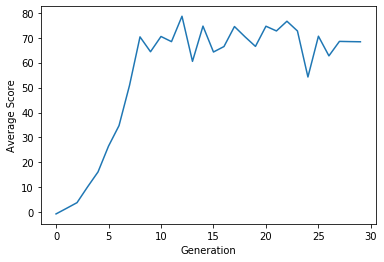

In [14]:
x = []
y = []
for i in range(num_gen):
    x.append(i)

for score in allScores:
    y.append(score[2])
plt.xlabel('Generation')
plt.ylabel('Average Score')
plt.plot(x, y)
plt.show()

### Diagnostics

In [15]:
# find all q values that correspond to given team
def find_team_q (q_table, team):
    result = []  
    for entry in q_table.q:
        if entry['team'] == str(team.id):
            result.append(entry)
    return result

# TODO better organize this for quicker analysis
def display_q (result):
    for entry in result:
        print(entry)

In [16]:
# run a given team after training
def post_training_run (q_table, team, epsilon, alpha, discount):
    env.reset()
    l_t, a_t = evaluate(team, env.current_state, q_table, epsilon)
    states = []
    print(states)
    states.append(env.current_state)    
    t = 0
    t_max = 50
    total_reward = 0
    while t < t_max:
        s_next, reward, isDone = env.step(a_t)
        states.append(s_next)
        total_reward += reward
        if isDone:
            return states, total_reward
        l_next, a_next = evaluate(team, env.current_state, q_table, epsilon)
        print('State: ' + str(s_next) + ' Action: ' + str(a_next))
        if l_t.id != l_next.id:
            print('Switching Learners!')
            print('Learner: ' + str(l_next.id))
            update(q_table, team, l_next, a_t, l_t, reward, alpha, epsilon)
        a_t = a_next
        l_t = l_next
        t = t + 1
    return states, total_reward

In [17]:
# run tests on champion
champ_table = find_team_q(table, champion)
display_q(champ_table)
for learner in champion.learners:
    print(learner.id)

{'team': '9147b2bb-f0f1-4a9f-b7da-86aeda21ded7', 'learner': '23f322c2-64e2-430c-9c0b-4deebe545f66', 'action': 2, 'q': 0.503770187367584}
{'team': '9147b2bb-f0f1-4a9f-b7da-86aeda21ded7', 'learner': '23f322c2-64e2-430c-9c0b-4deebe545f66', 'action': 1, 'q': 0.18754200615787375}
{'team': '9147b2bb-f0f1-4a9f-b7da-86aeda21ded7', 'learner': '8d6db57c-05f0-4626-bd87-a4d1ab2f6400', 'action': 1, 'q': 0}
{'team': '9147b2bb-f0f1-4a9f-b7da-86aeda21ded7', 'learner': '8d6db57c-05f0-4626-bd87-a4d1ab2f6400', 'action': 2, 'q': 0}
{'team': '9147b2bb-f0f1-4a9f-b7da-86aeda21ded7', 'learner': '8d6db57c-05f0-4626-bd87-a4d1ab2f6400', 'action': 0, 'q': 0}
{'team': '9147b2bb-f0f1-4a9f-b7da-86aeda21ded7', 'learner': '85da77c4-35d5-400f-b2a7-fbdd0bffb684', 'action': 0, 'q': 0.5243054458585779}
{'team': '9147b2bb-f0f1-4a9f-b7da-86aeda21ded7', 'learner': '3576a35d-e707-4b0a-bda9-28f232e1c522', 'action': 1, 'q': 0.5366184833921849}
{'team': '9147b2bb-f0f1-4a9f-b7da-86aeda21ded7', 'learner': '3fde6c30-d0a1-4038-aa1d-

In [18]:
# uses same epsilon, alpha, and discount values as defined prior
states, score = post_training_run(table, champion, epsilon, alpha, discount)
print(score)

[]
State: (3, 0) Action: 1
Switching Learners!
Learner: 3576a35d-e707-4b0a-bda9-28f232e1c522
State: (4, 0) Action: 0
Switching Learners!
Learner: 85da77c4-35d5-400f-b2a7-fbdd0bffb684
State: (3, 0) Action: 1
Switching Learners!
Learner: 3576a35d-e707-4b0a-bda9-28f232e1c522
State: (4, 0) Action: 0
Switching Learners!
Learner: 85da77c4-35d5-400f-b2a7-fbdd0bffb684
State: (3, 0) Action: 2
Switching Learners!
Learner: 23f322c2-64e2-430c-9c0b-4deebe545f66
State: (3, 1) Action: 0
Switching Learners!
Learner: 85da77c4-35d5-400f-b2a7-fbdd0bffb684
State: (3, 1) Action: 1
Switching Learners!
Learner: 3576a35d-e707-4b0a-bda9-28f232e1c522
State: (4, 1) Action: 0
Switching Learners!
Learner: 85da77c4-35d5-400f-b2a7-fbdd0bffb684
State: (3, 1) Action: 1
Switching Learners!
Learner: 3576a35d-e707-4b0a-bda9-28f232e1c522
State: (4, 1) Action: 0
Switching Learners!
Learner: 85da77c4-35d5-400f-b2a7-fbdd0bffb684
State: (3, 1) Action: 2
Switching Learners!
Learner: 23f322c2-64e2-430c-9c0b-4deebe545f66
State: 

In [19]:
env.animate_path(states)

36
[[0. 0. 0. 0. 1.]
 [0. 5. 0. 5. 0.]
 [5. 5. 0. 5. 5.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
